In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
import sys
sys.path.append("../src/")
import json

import numpy as np
import pandas as pd
import math
from datasets import Dataset, list_metrics, load_metric
from transformers import AutoConfig, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling, Trainer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from results_analysis.analyze_exp_results import ExpAnalyzer
from results_analysis.analyze_per_user_exp_results import PerUserExpAnalyzer
from results_analysis.analysis_utils import plot_user_perf_by_sample_count

In [5]:
base_result_dir = "/data/ddmg/redditlanguagemodeling/results/"

In [6]:
# load data used
data_df = pd.read_csv("/data/ddmg/redditlanguagemodeling/data/3_all_data_user_filtered_2021-06-21.csv")

In [50]:
36522 / 1342252

0.027209495683373913

In [51]:
train_df = data_df[data_df["data_split"] == "train"]

In [53]:
# get train counts by user
user_counts = train_df.groupby("author").count()["id"]
user_counts

author
101111                25
123wanderlust         18
19931                 27
1blockologist         33
1gudboi               24
                      ..
your_godammn_right    20
zcc0nonA              22
zomgitsduke           22
ztsmart               27
zuelearth             22
Name: id, Length: 583, dtype: int64

In [59]:
# restrict to just users in test group
val_df = data_df[data_df["data_split"] == "val"]
test_users = set(val_df["author"])
len(test_users)

50

In [60]:
user_counts = user_counts[user_counts.index.isin(test_users)]

In [62]:
user_counts

author
BRoccoli20              21
Chad_arbc               30
Creative310             21
Dotabjj                 18
Eriflee                 19
GaniB                   19
HelloImLucas            20
IckyBelly               18
KarmaKingKong           66
Kennyv777               18
KharnTheBetrayer1997    19
MartEden                94
Olliebkl                18
Ps4gal94                52
Thatawkwardhipster      20
Tony0x01                22
Unclebunt92             21
WarKittyKat             31
americanpegasus         72
anonymous_user_x        21
binarygold              24
blossbloss              28
bluejeans90210          21
brookswilliams          39
closingbell             19
cqm                     32
cwrace71                18
davidcwilliams          35
eclecticuniversalas     19
eiidunncnsj             18
escapevelo              20
exab                    85
frostmas                33
glittertoes1            26
goodDayM                21
goodluckchuck11         40
hgmichna             

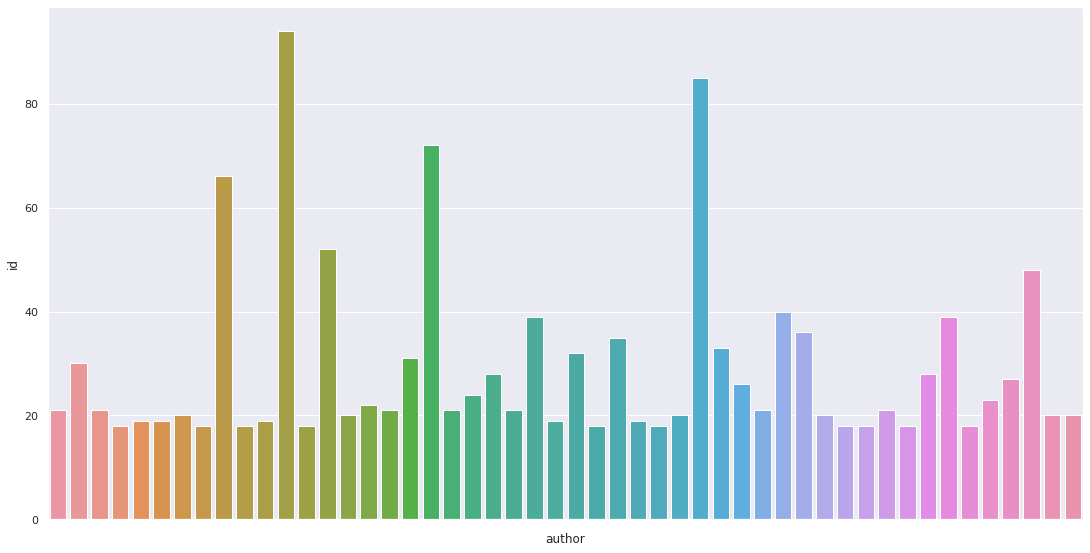

<Figure size 432x288 with 0 Axes>

In [61]:
plt.figure(figsize=(16, 8))
sns.barplot(x=user_counts.index, y=user_counts)
plt.tight_layout()
locs, labels = plt.xticks()
plt.xticks(locs, [])  # don't show x-ticks because it looks messy with so many authors
plt.show()
plt.clf()

In [45]:
data_df

,Unnamed: 0,id,author,data_split,subreddit,text,created_utc
0,892,2v244r,Sheehan7,train,AskDocs,I'm 18 and might have sciatica. Most of the pe...,1.423280e+09
1,991,2wyf6l,anu72,train,AskDocs,Best course for pain related to Fibromyalgia I...,1.424753e+09
2,1473,2x4so9,Sheehan7,train,AskDocs,I was referred to a neurosurgeon for an MRI bu...,1.424886e+09
3,1701,2yiit6,Jcorb,train,AskDocs,Best way to relieve a headache that you are AL...,1.425954e+09
4,4126,3av69z,Sheehan7,train,AskDocs,Can seasonal allergies yield more extreme symp...,1.435088e+09
...,...,...,...,...,...,...,...
22674,1244202,7cto8b,Eriflee,test,relationships,Coworker[24F] has crippling low self-confidenc...,1.510640e+09
22675,1315905,bo9z2x,robert323445,test,relationships,Girl said on our date that ‘the guys at our sc...,1.557785e+09
22676,1331376,d7owo4,Eriflee,test,relationships,"I[27M] was given a better job offer, but my de...",1.569150e+09
22677,1349175,f85hph,robert323445,test,relationships,Should I 23M try to escalate things with her 2...,1.582437e+09


## Baseline #1: pre-trained DistilBERT, no fine-tuning

In [4]:
result_dir1 = os.path.join(base_result_dir, "1_bert_distill_pretrained")

In [5]:
exp_analyzer1 = ExpAnalyzer(result_dir1)

In [7]:
exp_analyzer1.data_split_perf_df

,data_split,loss,perplexity
0,eval,2.888228,17.961461
1,test,2.914612,18.441652


In [67]:
exp_analyzer1.author_result_df

,author,loss,perplexity
0,BRoccoli20,2.734233,15.397927
1,Chad_arbc,2.928797,18.705110
2,Creative310,3.261148,26.079471
3,Dotabjj,3.900943,49.449071
4,Eriflee,2.603933,13.516790
5,GaniB,2.536566,12.636204
6,HelloImLucas,2.977928,19.647074
7,IckyBelly,3.283250,26.662274
8,KarmaKingKong,3.053627,21.192074
9,Kennyv777,3.029405,20.684929


In [68]:
exp_analyzer1.author_result_df.mean()

loss           2.939632
perplexity    21.095752
dtype: float64

In [69]:
exp_analyzer1.author_result_df.std()

loss           0.465019
perplexity    11.119500
dtype: float64

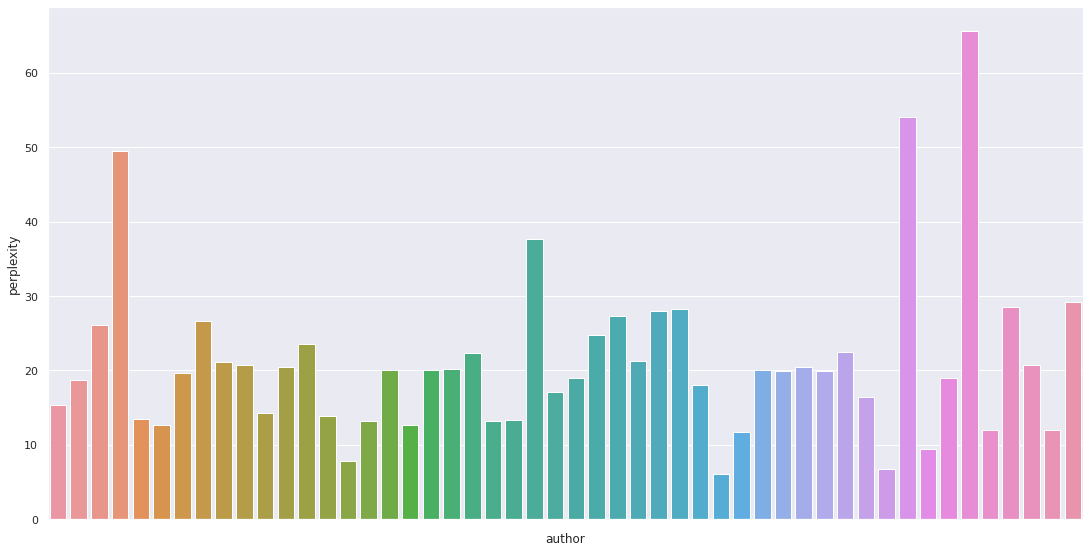

<Figure size 432x288 with 0 Axes>

In [74]:
exp_analyzer1.plot_perf_by_author("perplexity")

r=-0.10404020197247915, p=0.4721268670615528


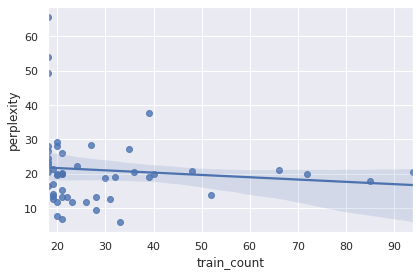

<Figure size 432x288 with 0 Axes>

In [150]:
plot_user_perf_by_sample_count(exp_analyzer1.author_result_df, user_counts, "perplexity")

<AxesSubplot:xlabel='train_count', ylabel='pretrained_perplexity'>

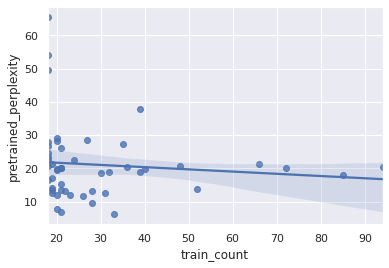

In [149]:
sns.regplot(data=merged_df2, x="train_count", y="pretrained_perplexity")

## Baseline #2: DistilBERT + fine-tune all

In [9]:
result_dir2 = os.path.join(base_result_dir, "2_distilbert_finetuned_all")
exp_analyzer2 = ExpAnalyzer(result_dir2)

In [12]:
exp_analyzer2.data_split_perf_df

,data_split,loss,perplexity
0,train,2.034210,7.646207
1,eval,2.162993,8.697127
2,test,2.170424,8.762000


In [151]:
exp_analyzer2.author_result_df.mean()

loss            2.193559
perplexity      9.802329
train_count    29.040000
dtype: float64

In [76]:
exp_analyzer2.author_result_df.std()

loss          0.420160
perplexity    4.624761
dtype: float64

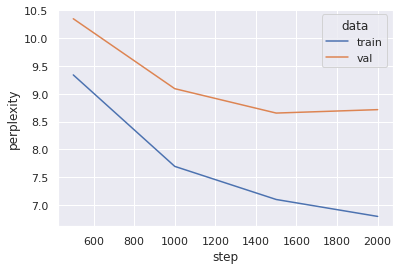

<Figure size 432x288 with 0 Axes>

In [14]:
exp_analyzer2.plot_metric_hist("perplexity")

In [10]:
result_dir2a = os.path.join(base_result_dir, "2a_distilbert_finetuned_all_eval")
exp_analyzer2a = ExpAnalyzer(result_dir2a)

In [13]:
exp_analyzer2a.data_split_perf_df

,data_split,loss,perplexity
0,test,2.150127,8.585946


In [63]:
exp_analyzer2a.author_result_df["train_count"] = exp_analyzer2a.author_result_df["author"].apply(lambda x: user_counts.loc[x])

In [64]:
exp_analyzer2a.author_result_df

,author,loss,perplexity,train_count
0,BRoccoli20,1.948978,7.021507,21
1,Chad_arbc,2.310407,10.078530,30
2,Creative310,2.679770,14.581736,21
3,Dotabjj,3.353760,28.610113,18
4,Eriflee,1.930120,6.890340,19
5,GaniB,1.769903,5.870284,19
6,HelloImLucas,2.191763,8.950983,20
7,IckyBelly,2.489771,12.058516,18
8,KarmaKingKong,2.082152,8.021716,66
9,Kennyv777,2.123868,8.363425,18


In [16]:
exp_analyzer2a.author_result_df.mean()

loss          2.173321
perplexity    9.613068
dtype: float64

In [17]:
exp_analyzer2a.author_result_df.std()

loss          0.420859
perplexity    4.586378
dtype: float64

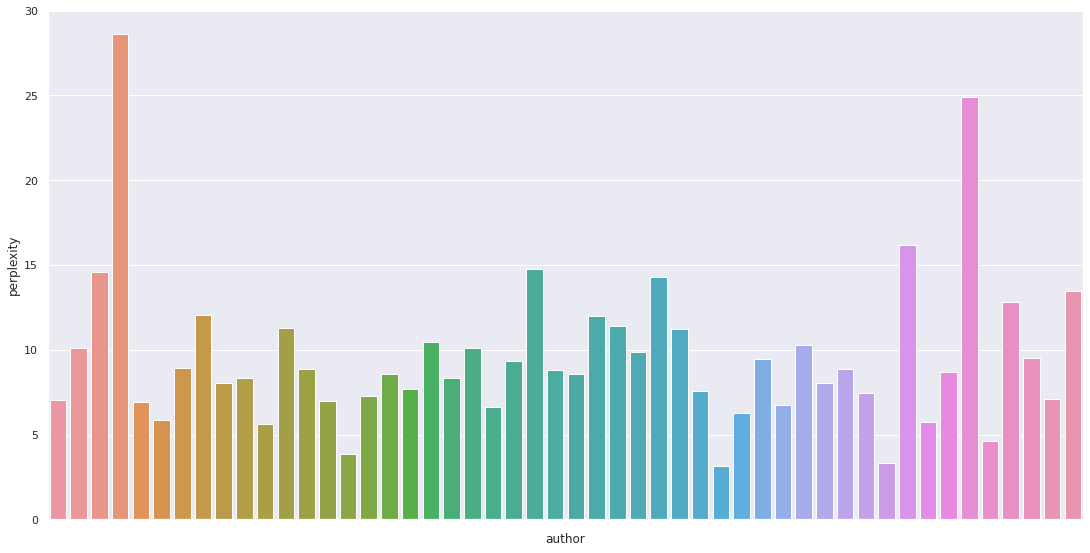

<Figure size 432x288 with 0 Axes>

In [77]:
exp_analyzer2a.plot_perf_by_author("perplexity")

r=-0.08604049118822453, p=0.5524362349920809


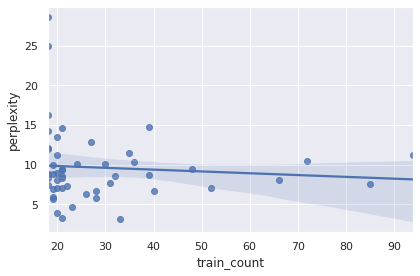

<Figure size 432x288 with 0 Axes>

In [152]:
plot_user_perf_by_sample_count(exp_analyzer2a.author_result_df, user_counts, "perplexity")

<AxesSubplot:xlabel='train_count', ylabel='fine-tune-all_perplexity'>

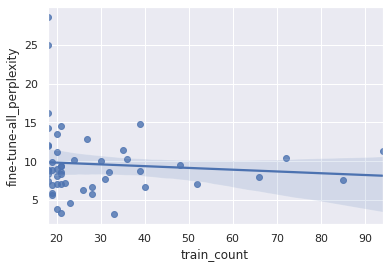

In [153]:
sns.regplot(data=merged_df2, x="train_count", y="fine-tune-all_perplexity")

## Baseline #3: DistilBERT fine-tuned for each user

In [7]:
result_dir3 = os.path.join(base_result_dir, "3_distilbert_finetuned_author")

In [8]:
exp_analyzer3 = PerUserExpAnalyzer(result_dir3)

Found results for 50 users


In [9]:
exp_analyzer3.data_split_perf_df

,data_split,loss,perplexity,author
0,train,2.704621,14.948650,IckyBelly
1,eval,2.427572,11.331336,IckyBelly
2,test,2.621368,13.754533,IckyBelly
0,train,2.941266,18.939810,BRoccoli20
1,eval,2.539243,12.670070,BRoccoli20
...,...,...,...,...
1,eval,3.462969,31.911576,eiidunncnsj
2,test,2.640532,14.020664,eiidunncnsj
0,train,2.568294,13.043552,Ps4gal94
1,eval,2.369963,10.697001,Ps4gal94


In [10]:
test_df = exp_analyzer3.data_split_perf_df[exp_analyzer3.data_split_perf_df["data_split"] == "test"]

In [11]:
test_df

,data_split,loss,perplexity,author
2,test,2.621368,13.754533,IckyBelly
2,test,2.606155,13.546865,BRoccoli20
2,test,2.617563,13.702291,Eriflee
2,test,2.599850,13.461724,svet_sedov
2,test,2.660373,14.301622,brookswilliams
2,test,2.632533,13.908961,goodDayM
2,test,2.597772,13.433769,MartEden
2,test,2.642845,14.053130,Dotabjj
2,test,2.611326,13.617092,KarmaKingKong
2,test,2.655383,14.230430,GaniB


In [12]:
test_df.mean()

loss           2.626411
perplexity    13.826180
dtype: float64

In [13]:
test_df.std()

loss          0.017583
perplexity    0.245316
dtype: float64

In [16]:
val_df.mean()

loss           2.620498
perplexity    15.191195
dtype: float64

In [17]:
val_df.std()

loss          0.420495
perplexity    8.270982
dtype: float64

In [15]:
val_df = exp_analyzer3.data_split_perf_df[exp_analyzer3.data_split_perf_df["data_split"] == "eval"]
val_df

,data_split,loss,perplexity,author
1,eval,2.427572,11.331336,IckyBelly
1,eval,2.539243,12.670070,BRoccoli20
1,eval,2.409674,11.130331,Eriflee
1,eval,2.372496,10.724125,svet_sedov
1,eval,3.945339,51.693845,brookswilliams
1,eval,2.325052,10.227217,goodDayM
1,eval,2.715629,15.114112,MartEden
1,eval,3.179774,24.041321,Dotabjj
1,eval,2.857913,17.425119,KarmaKingKong
1,eval,2.747076,15.596960,GaniB


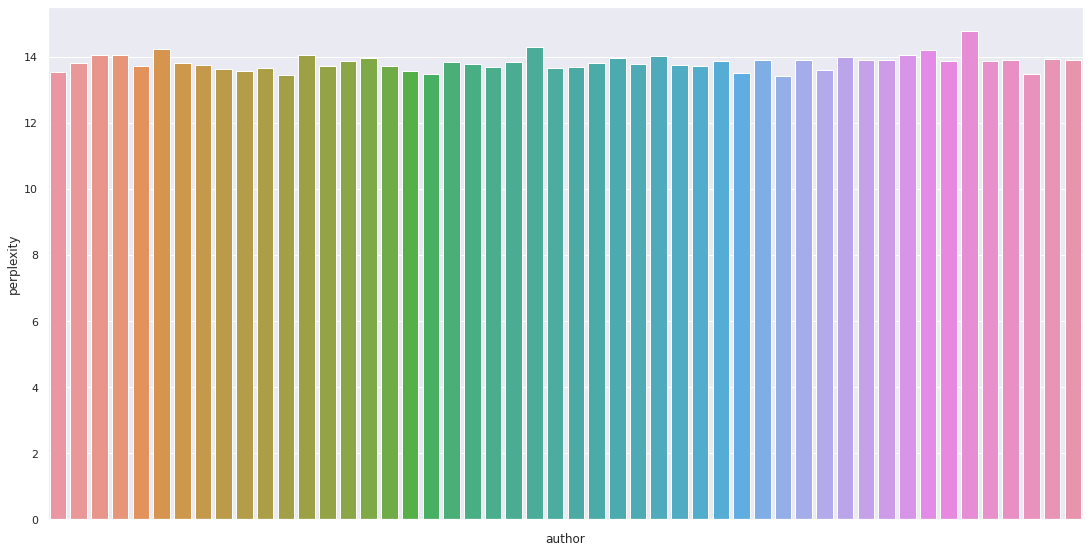

<Figure size 432x288 with 0 Axes>

In [79]:
exp_analyzer3.plot_perf_by_author("test", "perplexity")

/data/ddmg/redditlanguagemodeling/reddit-personalized-lm/notebooks/../src/results_analysis/analysis_utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_result_df["train_count"] = user_result_df["author"].apply(lambda x: user_counts.loc[x])


r=-0.37579755992697034, p=0.007157170828543561


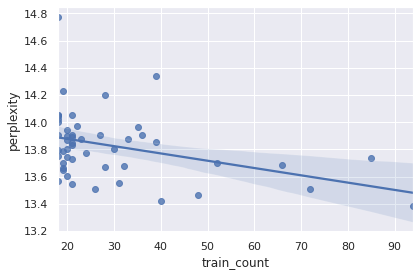

<Figure size 432x288 with 0 Axes>

In [154]:
plot_user_perf_by_sample_count(test_df, user_counts, "perplexity")

<AxesSubplot:xlabel='train_count', ylabel='fine-tune-user_perplexity'>

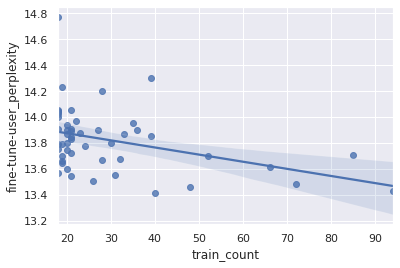

In [155]:
sns.regplot(data=merged_df2, x="train_count", y="fine-tune-user_perplexity")

In [92]:
exp_analyzer3.user_results.keys()

dict_keys(['IckyBelly', 'BRoccoli20', 'Eriflee', 'svet_sedov', 'brookswilliams', 'goodDayM', 'MartEden', 'Dotabjj', 'KarmaKingKong', 'GaniB', 'anonymous_user_x', 'WarKittyKat', 'americanpegasus', 'blossbloss', 'libelulas3v3n', 'glittertoes1', 'hgmichna', 'your_godammn_right', 'mastermascovich', 'Olliebkl', 'peimom123', 'robert323445', 'hrrm', 'cwrace71', 'Creative310', 'escapevelo', 'Chad_arbc', 'itsnotthot', 'frostmas', 'lightlasertower', 'eclecticuniversalas', 'Kennyv777', 'wsace', 'Unclebunt92', 'binarygold', 'bluejeans90210', 'Thatawkwardhipster', 'davidcwilliams', 'Tony0x01', 'goodluckchuck11', 'closingbell', 'HelloImLucas', 'skabaw', 'cqm', 'KharnTheBetrayer1997', 'retardedinvestor', 'exab', 'jdino23', 'eiidunncnsj', 'Ps4gal94'])

In [94]:
exp_analyzer3.user_results['IckyBelly'].trainer_state

{'best_metric': None,
 'best_model_checkpoint': None,
 'epoch': 3.0,
 'global_step': 3,
 'is_hyper_param_search': False,
 'is_local_process_zero': True,
 'is_world_process_zero': True,
 'log_history': [{'epoch': 3.0,
   'step': 3,
   'total_flos': 11112095600640.0,
   'train_runtime': 1.1359,
   'train_samples_per_second': 2.641}],
 'max_steps': 3,
 'num_train_epochs': 3,
 'total_flos': 11112095600640.0,
 'trial_name': None,
 'trial_params': None}

In [100]:
# analyze performance difference between all-fine-tune and user-fine-tune
user_fine_tune_df = test_df
user_fine_tune_df = user_fine_tune_df.rename(columns={"loss": "fine-tune-user_loss", "perplexity": "fine-tune-user_perplexity"})
user_fine_tune_df

,data_split,fine-tune-user_loss,fine-tune-user_perplexity,author,exp
2,test,2.621368,13.754533,IckyBelly,user_fine_tune
2,test,2.606155,13.546865,BRoccoli20,user_fine_tune
2,test,2.617563,13.702291,Eriflee,user_fine_tune
2,test,2.599850,13.461724,svet_sedov,user_fine_tune
2,test,2.660373,14.301622,brookswilliams,user_fine_tune
2,test,2.632533,13.908961,goodDayM,user_fine_tune
2,test,2.597772,13.433769,MartEden,user_fine_tune
2,test,2.642845,14.053130,Dotabjj,user_fine_tune
2,test,2.611326,13.617092,KarmaKingKong,user_fine_tune
2,test,2.655383,14.230430,GaniB,user_fine_tune


In [99]:
all_fine_tune_df = exp_analyzer2a.author_result_df
all_fine_tune_df = all_fine_tune_df.rename(columns={"loss": "fine-tune-all_loss", "perplexity": "fine-tune-all_perplexity"})
all_fine_tune_df

,author,fine-tune-all_loss,fine-tune-all_perplexity,train_count,exp
0,BRoccoli20,1.948978,7.021507,21,all_fine_tune
1,Chad_arbc,2.310407,10.078530,30,all_fine_tune
2,Creative310,2.679770,14.581736,21,all_fine_tune
3,Dotabjj,3.353760,28.610113,18,all_fine_tune
4,Eriflee,1.930120,6.890340,19,all_fine_tune
5,GaniB,1.769903,5.870284,19,all_fine_tune
6,HelloImLucas,2.191763,8.950983,20,all_fine_tune
7,IckyBelly,2.489771,12.058516,18,all_fine_tune
8,KarmaKingKong,2.082152,8.021716,66,all_fine_tune
9,Kennyv777,2.123868,8.363425,18,all_fine_tune


In [101]:
merged_df = all_fine_tune_df.merge(user_fine_tune_df, how='inner', on="author")
merged_df

,author,fine-tune-all_loss,fine-tune-all_perplexity,train_count,exp_x,data_split,fine-tune-user_loss,fine-tune-user_perplexity,exp_y
0,BRoccoli20,1.948978,7.021507,21,all_fine_tune,test,2.606155,13.546865,user_fine_tune
1,Chad_arbc,2.310407,10.078530,30,all_fine_tune,test,2.624900,13.803195,user_fine_tune
2,Creative310,2.679770,14.581736,21,all_fine_tune,test,2.642944,14.054521,user_fine_tune
3,Dotabjj,3.353760,28.610113,18,all_fine_tune,test,2.642845,14.053130,user_fine_tune
4,Eriflee,1.930120,6.890340,19,all_fine_tune,test,2.617563,13.702291,user_fine_tune
5,GaniB,1.769903,5.870284,19,all_fine_tune,test,2.655383,14.230430,user_fine_tune
6,HelloImLucas,2.191763,8.950983,20,all_fine_tune,test,2.624713,13.800615,user_fine_tune
7,IckyBelly,2.489771,12.058516,18,all_fine_tune,test,2.621368,13.754533,user_fine_tune
8,KarmaKingKong,2.082152,8.021716,66,all_fine_tune,test,2.611326,13.617092,user_fine_tune
9,Kennyv777,2.123868,8.363425,18,all_fine_tune,test,2.607631,13.566879,user_fine_tune


In [103]:
merged_df["perplexity_diff"] = merged_df.apply(lambda x: x["fine-tune-all_perplexity"] - x["fine-tune-user_perplexity"], axis=1)

In [104]:
merged_df

,author,fine-tune-all_loss,fine-tune-all_perplexity,train_count,exp_x,data_split,fine-tune-user_loss,fine-tune-user_perplexity,exp_y,perplexity_diff
0,BRoccoli20,1.948978,7.021507,21,all_fine_tune,test,2.606155,13.546865,user_fine_tune,-6.525358
1,Chad_arbc,2.310407,10.078530,30,all_fine_tune,test,2.624900,13.803195,user_fine_tune,-3.724665
2,Creative310,2.679770,14.581736,21,all_fine_tune,test,2.642944,14.054521,user_fine_tune,0.527215
3,Dotabjj,3.353760,28.610113,18,all_fine_tune,test,2.642845,14.053130,user_fine_tune,14.556982
4,Eriflee,1.930120,6.890340,19,all_fine_tune,test,2.617563,13.702291,user_fine_tune,-6.811950
5,GaniB,1.769903,5.870284,19,all_fine_tune,test,2.655383,14.230430,user_fine_tune,-8.360146
6,HelloImLucas,2.191763,8.950983,20,all_fine_tune,test,2.624713,13.800615,user_fine_tune,-4.849632
7,IckyBelly,2.489771,12.058516,18,all_fine_tune,test,2.621368,13.754533,user_fine_tune,-1.696017
8,KarmaKingKong,2.082152,8.021716,66,all_fine_tune,test,2.611326,13.617092,user_fine_tune,-5.595376
9,Kennyv777,2.123868,8.363425,18,all_fine_tune,test,2.607631,13.566879,user_fine_tune,-5.203454


In [116]:
global_result_df = exp_analyzer1.author_result_df.rename(columns={"loss": "pretrained_loss", "perplexity": "pretrained_perplexity"})
merged_df2 = merged_df.merge(global_result_df, how='inner', on='author')

In [117]:
merged_df2

,author,fine-tune-all_loss,fine-tune-all_perplexity,train_count_x,exp_x,data_split,fine-tune-user_loss,fine-tune-user_perplexity,exp_y,perplexity_diff,pretrained_loss,pretrained_perplexity,train_count_y
0,BRoccoli20,1.948978,7.021507,21,all_fine_tune,test,2.606155,13.546865,user_fine_tune,-6.525358,2.734233,15.397927,21
1,Chad_arbc,2.310407,10.078530,30,all_fine_tune,test,2.624900,13.803195,user_fine_tune,-3.724665,2.928797,18.705110,30
2,Creative310,2.679770,14.581736,21,all_fine_tune,test,2.642944,14.054521,user_fine_tune,0.527215,3.261148,26.079471,21
3,Dotabjj,3.353760,28.610113,18,all_fine_tune,test,2.642845,14.053130,user_fine_tune,14.556982,3.900943,49.449071,18
4,Eriflee,1.930120,6.890340,19,all_fine_tune,test,2.617563,13.702291,user_fine_tune,-6.811950,2.603933,13.516790,19
5,GaniB,1.769903,5.870284,19,all_fine_tune,test,2.655383,14.230430,user_fine_tune,-8.360146,2.536566,12.636204,19
6,HelloImLucas,2.191763,8.950983,20,all_fine_tune,test,2.624713,13.800615,user_fine_tune,-4.849632,2.977928,19.647074,20
7,IckyBelly,2.489771,12.058516,18,all_fine_tune,test,2.621368,13.754533,user_fine_tune,-1.696017,3.283250,26.662274,18
8,KarmaKingKong,2.082152,8.021716,66,all_fine_tune,test,2.611326,13.617092,user_fine_tune,-5.595376,3.053627,21.192074,66
9,Kennyv777,2.123868,8.363425,18,all_fine_tune,test,2.607631,13.566879,user_fine_tune,-5.203454,3.029405,20.684929,18


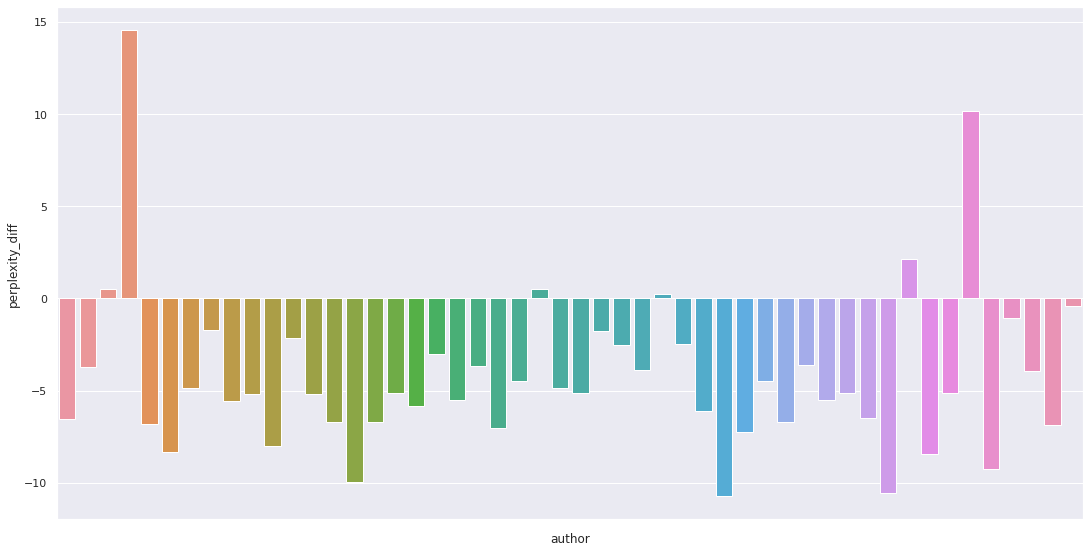

<Figure size 432x288 with 0 Axes>

In [105]:
merged_df = merged_df.sort_values("author")
plt.figure(figsize=(16, 8))
sns.barplot(data=merged_df, x="author", y="perplexity_diff")
plt.tight_layout()
locs, labels = plt.xticks()
plt.xticks(locs, [])  # don't show x-ticks because it looks messy with so many authors
plt.show()
plt.clf()


r=-0.06691593772228607, p=0.6442839247878063


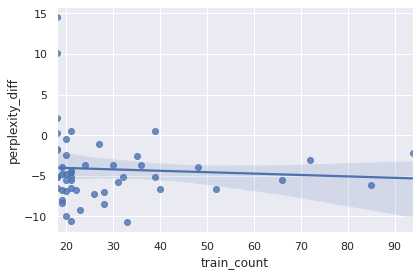

<Figure size 432x288 with 0 Axes>

In [107]:
plot_user_perf_by_sample_count(merged_df, user_counts, "perplexity_diff")

In [120]:
merged_df2[merged_df2["perplexity_diff"] > 0][['author','pretrained_perplexity', 'fine-tune-all_perplexity', 'fine-tune-user_perplexity', 'perplexity_diff', 'train_count_x']]

,author,pretrained_perplexity,fine-tune-all_perplexity,fine-tune-user_perplexity,perplexity_diff,train_count_x
2,Creative310,26.079471,14.581736,14.054521,0.527215,21
3,Dotabjj,49.449071,28.610113,14.053130,14.556982,18
23,brookswilliams,37.701332,14.789476,14.301622,0.487854,39
29,eiidunncnsj,28.014919,14.275524,14.020664,0.254860,18
41,lightlasertower,54.034660,16.188387,14.050252,2.138135,18
44,retardedinvestor,65.583388,24.937709,14.773740,10.163969,18


In [121]:
merged_df2[['author','pretrained_perplexity', 'fine-tune-all_perplexity', 'fine-tune-user_perplexity', 'perplexity_diff', 'train_count_x']]

,author,pretrained_perplexity,fine-tune-all_perplexity,fine-tune-user_perplexity,perplexity_diff,train_count_x
0,BRoccoli20,15.397927,7.021507,13.546865,-6.525358,21
1,Chad_arbc,18.705110,10.078530,13.803195,-3.724665,30
2,Creative310,26.079471,14.581736,14.054521,0.527215,21
3,Dotabjj,49.449071,28.610113,14.053130,14.556982,18
4,Eriflee,13.516790,6.890340,13.702291,-6.811950,19
5,GaniB,12.636204,5.870284,14.230430,-8.360146,19
6,HelloImLucas,19.647074,8.950983,13.800615,-4.849632,20
7,IckyBelly,26.662274,12.058516,13.754533,-1.696017,18
8,KarmaKingKong,21.192074,8.021716,13.617092,-5.595376,66
9,Kennyv777,20.684929,8.363425,13.566879,-5.203454,18


In [122]:
from scipy.stats import pearsonr

In [123]:
pearsonr(merged_df2["pretrained_perplexity"], merged_df2["perplexity_diff"])

(0.9097153890638039, 5.974990784193593e-20)

<AxesSubplot:xlabel='pretrained_perplexity', ylabel='perplexity_diff'>

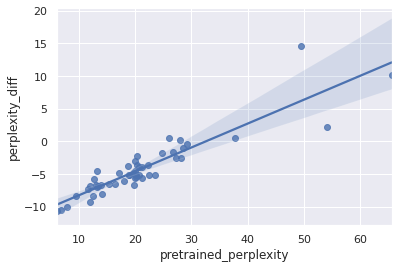

In [124]:
sns.regplot(data=merged_df2, x="pretrained_perplexity", y="perplexity_diff")

In [126]:
pearsonr(merged_df2["fine-tune-all_perplexity"], merged_df2["perplexity_diff"])

(0.9988292162847169, 8.34839004151572e-65)

<AxesSubplot:xlabel='fine-tune-all_perplexity', ylabel='perplexity_diff'>

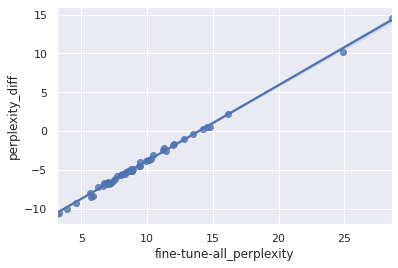

In [125]:
sns.regplot(data=merged_df2, x="fine-tune-all_perplexity", y="perplexity_diff")

In [128]:
merged_df2["fine-tune-all_perplexity_diff"] = merged_df2.apply(lambda x: x["pretrained_perplexity"] - x["fine-tune-all_perplexity"], axis=1)

In [129]:
merged_df2["fine-tune-user_perplexity_diff"] = merged_df2.apply(lambda x: x["pretrained_perplexity"] - x["fine-tune-user_perplexity"], axis=1)

In [159]:
merged_df2[['author','pretrained_perplexity', 'fine-tune-all_perplexity', 'fine-tune-user_perplexity', "fine-tune-user_perplexity_diff", 'train_count_x']]

,author,pretrained_perplexity,fine-tune-all_perplexity,fine-tune-user_perplexity,fine-tune-user_perplexity_diff,train_count_x
0,BRoccoli20,15.397927,7.021507,13.546865,1.851062,21
1,Chad_arbc,18.705110,10.078530,13.803195,4.901915,30
2,Creative310,26.079471,14.581736,14.054521,12.024950,21
3,Dotabjj,49.449071,28.610113,14.053130,35.395941,18
4,Eriflee,13.516790,6.890340,13.702291,-0.185500,19
5,GaniB,12.636204,5.870284,14.230430,-1.594226,19
6,HelloImLucas,19.647074,8.950983,13.800615,5.846458,20
7,IckyBelly,26.662274,12.058516,13.754533,12.907742,18
8,KarmaKingKong,21.192074,8.021716,13.617092,7.574983,66
9,Kennyv777,20.684929,8.363425,13.566879,7.118050,18


r=-0.10641876796469708, p=0.4620020635954476


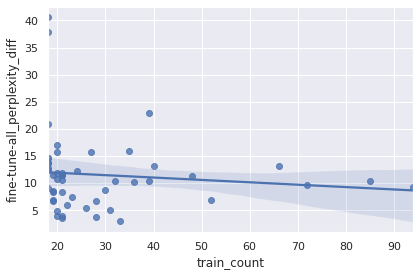

<Figure size 432x288 with 0 Axes>

In [158]:
plot_user_perf_by_sample_count(merged_df2, user_counts, "fine-tune-all_perplexity_diff")

r=-0.09656983817756316, p=0.504681118386536


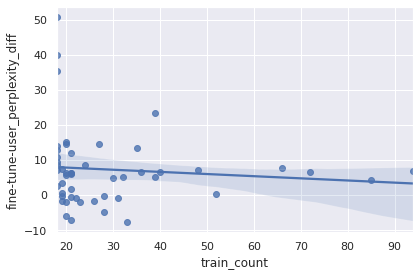

<Figure size 432x288 with 0 Axes>

In [160]:
plot_user_perf_by_sample_count(merged_df2, user_counts, "fine-tune-user_perplexity_diff")

In [161]:
result_dir3a = os.path.join(base_result_dir, "3a_distilbert_finetuned_author")

In [162]:
exp_analyzer3a = PerUserExpAnalyzer(result_dir3a)

Found results for 50 users


In [163]:
exp_analyzer3a.data_split_perf_df

,data_split,loss,perplexity,author
0,train,2.946713,19.043252,your_godammn_right
1,eval,2.385257,10.861849,your_godammn_right
2,test,2.629473,13.866460,your_godammn_right
0,train,2.496314,12.137670,WarKittyKat
1,eval,2.347596,10.460392,WarKittyKat
...,...,...,...,...
1,eval,2.756203,15.739971,hrrm
2,test,2.608983,13.585228,hrrm
0,train,2.777453,16.078021,wsace
1,eval,2.944245,18.996317,wsace


In [164]:
test_df = exp_analyzer3a.data_split_perf_df[exp_analyzer3a.data_split_perf_df["data_split"] == "test"]
test_df

,data_split,loss,perplexity,author
2,test,2.629473,13.866460,your_godammn_right
2,test,2.606630,13.553304,WarKittyKat
2,test,2.617902,13.706934,Eriflee
2,test,2.625945,13.817630,skabaw
2,test,2.628865,13.858035,robert323445
2,test,2.595722,13.406266,Ps4gal94
2,test,2.607301,13.562403,Kennyv777
2,test,2.626927,13.831203,bluejeans90210
2,test,2.638923,13.998125,davidcwilliams
2,test,2.653088,14.197819,Dotabjj


In [165]:
test_df.mean()

loss           2.626819
perplexity    13.832303
dtype: float64

In [166]:
test_df.std()

loss          0.019497
perplexity    0.272793
dtype: float64

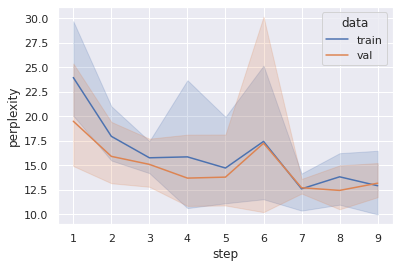

<Figure size 432x288 with 0 Axes>

In [167]:
exp_analyzer3a.plot_metric_hist("perplexity")

In [140]:
exp_analyzer3a.train_hist_df

,step,data,loss,perplexity,author
0,5.0,train,2.787900,16.246866,davidcwilliams
1,5.0,val,3.316482,27.563208,davidcwilliams
0,5.0,train,2.725600,15.265571,americanpegasus
1,5.0,val,2.507959,12.279837,americanpegasus
0,5.0,train,2.640000,14.013204,Ps4gal94
1,5.0,val,2.303717,10.011329,Ps4gal94
0,5.0,train,2.728300,15.306843,svet_sedov
1,5.0,val,2.340381,10.385189,svet_sedov
0,5.0,train,2.607400,13.563739,peimom123
1,5.0,val,2.617860,13.706365,peimom123


In [147]:
len(train_df[train_df["author"] == 'americanpegasus'])

72

In [148]:
72/32

2.25

In [146]:
exp_analyzer3a.user_results['americanpegasus'].trainer_state

{'best_metric': 2.5079586505889893,
 'best_model_checkpoint': '/data/ddmg/redditlanguagemodeling/results/3a_distilbert_finetuned_author/americanpegasus/checkpoint-5',
 'epoch': 3.0,
 'global_step': 9,
 'is_hyper_param_search': False,
 'is_local_process_zero': True,
 'is_world_process_zero': True,
 'log_history': [{'epoch': 1.67,
   'learning_rate': 2.2222222222222223e-05,
   'loss': 2.7256,
   'step': 5},
  {'epoch': 1.67,
   'eval_loss': 2.5079586505889893,
   'eval_runtime': 0.2495,
   'eval_samples_per_second': 96.194,
   'step': 5},
  {'epoch': 3.0,
   'step': 9,
   'total_flos': 16462363852800.0,
   'train_runtime': 12.8741,
   'train_samples_per_second': 0.699}],
 'max_steps': 9,
 'num_train_epochs': 3,
 'total_flos': 16462363852800.0,
 'trial_name': None,
 'trial_params': None}

In [141]:
exp_analyzer3a.user_results['IckyBelly'].train_hist_df

,step,data,loss,perplexity,author
